In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV


In [2]:
data_raw = pd.read_csv('Kaggle_Salary.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Question 1: Data Cleaning

## Remove Unnecessary Columns

This step is to remove undesired columns. These columns are consisted with those with 'OTHER_TEXT' in their titles and the first column. 'Q10_Encoded' will be used as target and thus 'Q10_buckets' and 'Q10' are removed.

In [0]:
data = data_raw[data_raw.columns.drop(list(data_raw.filter(regex='TEXT')))]
data = data.drop(['Time from Start to Finish (seconds)'],axis=1)
data = data.drop(['Q10_buckets','Q10'],axis=1)

## Encode Multi-parts Questions

For this type of questions, participants choose one of more from the choices provided and therefore results in many unselected ones (NaN) in the dataframe. The encoding of this type of questions is completed according to the following steps:


1.   Replace selected ones by 1 and non-selected ones by 0.
2.   Sum up the selected options (except for the 'None' option) of each participant for each question and create a new feature with the sum.



In [0]:
numofentries = data.shape[0]

def multichoice(col,numofparts):
  colindex = data.columns.get_loc(col+'_Part_'+str(numofparts))
  data.insert(colindex+1, col+'_sum', [0]*numofentries, True)
  for i in range(numofparts):
    data[col+'_Part_'+str(i+1)]=data[col+'_Part_'+str(i+1)].notnull().astype(int)
    if i != numofparts-2:
      data[col+'_sum'] = data[col+'_sum'] + data[col+'_Part_'+str(i+1)]
  return data[col+'_sum'] 

In [0]:
Q9_sum = multichoice('Q9',8)
Q12_sum = multichoice('Q12',12)
Q13_sum = multichoice('Q13',12)
Q16_sum = multichoice('Q16',12)
Q17_sum = multichoice('Q17',12)
Q18_sum = multichoice('Q18',12)
Q20_sum = multichoice('Q20',12)
Q21_sum = multichoice('Q21',5)
Q24_sum = multichoice('Q24',12)
Q25_sum = multichoice('Q25',8)
Q26_sum = multichoice('Q26',7)
Q27_sum = multichoice('Q27',6)
Q28_sum = multichoice('Q28',12)
Q29_sum = multichoice('Q29',12)
Q30_sum = multichoice('Q30',12)
Q31_sum = multichoice('Q31',12)
Q32_sum = multichoice('Q32',12)
Q33_sum = multichoice('Q33',12)
Q34_sum = multichoice('Q34',12)


## Handle Missing Value

As the previous section handled most of the NaNs in the dataset, before moving on to encode other questions, let's plot a heatmap to find out the distribution of the remaining missing values.

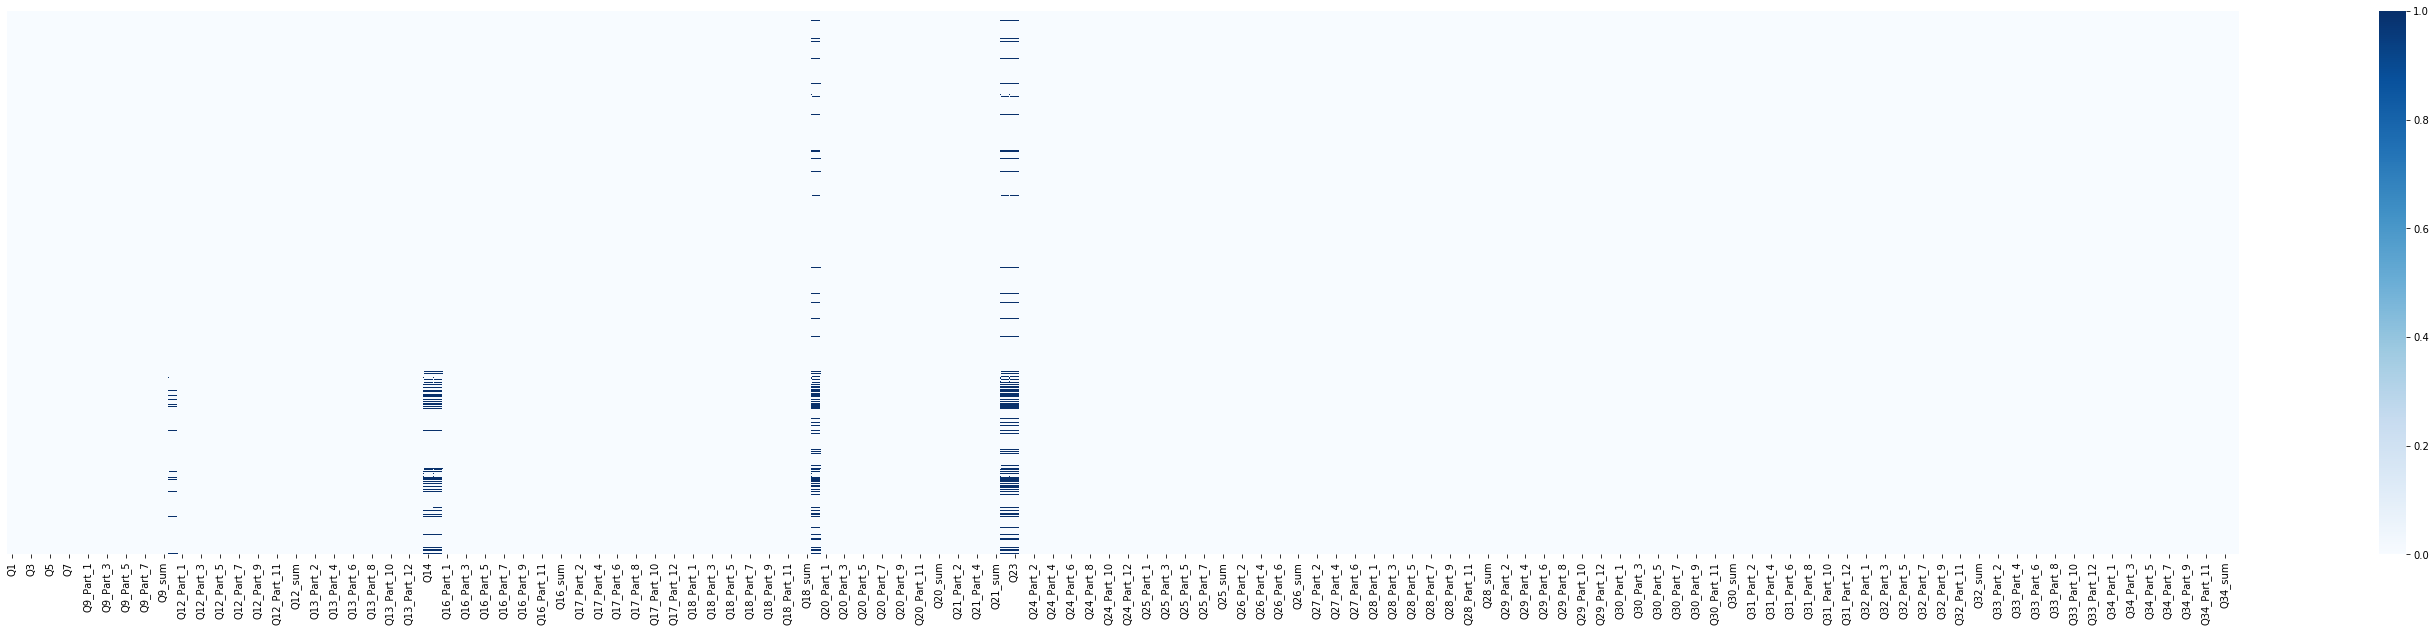

In [6]:
plt.figure(figsize=(50,10))
mv_heatmap1 = sns.heatmap(data.isnull(),cmap='Blues',yticklabels=False)
plt.xticks(rotation=90)
plt.show()

It is find out that column Q11, Q14, Q15, Q19, Q22, Q23 still have missing values. Now let's look into these columns one by one. 

First of all, Q11 asks how much money the participant has spent on machine learning or cloud computing products. In this case, people did not answer the question are more likely on the lowered end (0 USD) of the categories.

In [7]:
data['Q11'].value_counts()

$0 (USD)             4038
$100-$999            2335
$1000-$9,999         2123
$1-$99               1485
$10,000-$99,999      1268
> $100,000 ($USD)    1001
Name: Q11, dtype: int64

The mode of all the participants is also '0 (USD)'. In this case, the NaN in column Q11 is filled by '$0 (USD)' as below.

In [0]:
data['Q11']=data['Q11'].fillna('$0 (USD)')

Q14 asks for the primary tool for analyzing data. The mode is 'Local development environments (RStudio, JupyterLab, etc.)'. Similar to previous one, the NaNs are filled by the mode.

In [0]:
data['Q14']=data['Q14'].fillna('Local development environments (RStudio, JupyterLab, etc.')

Q15 asks how long the participant has been writing code to analyze data. Although the mode of the answers is '3-5 years', it is more likely that people did not answer this question because they 'have never written code'. Hence, the NaNs are filled by this option as below.

In [0]:
data['Q15']=data['Q15'].fillna('I have never written code')

Q19 asks what programming language the participant would recommend an aspiring data scientist to learn first. The mode is 'Python' and the NaNs are filled accordingly.

In [0]:
data['Q19']=data['Q19'].fillna('Python')

Q22 asks the participants if they have used a tensor processing unit. Similar to Q11, the mode is 'Never' and it is also the most possible answer for people skip this question.

In [0]:
data['Q22']=data['Q22'].fillna('Never')

Q23 asks for how many times the participant have used machine learning methods. Similar to Q22, the NaNs are filled with '< 1 years'.

In [0]:
data['Q23']=data['Q23'].fillna('< 1 years')

Now let's plot the heatmap again to check if there is any NaN left.

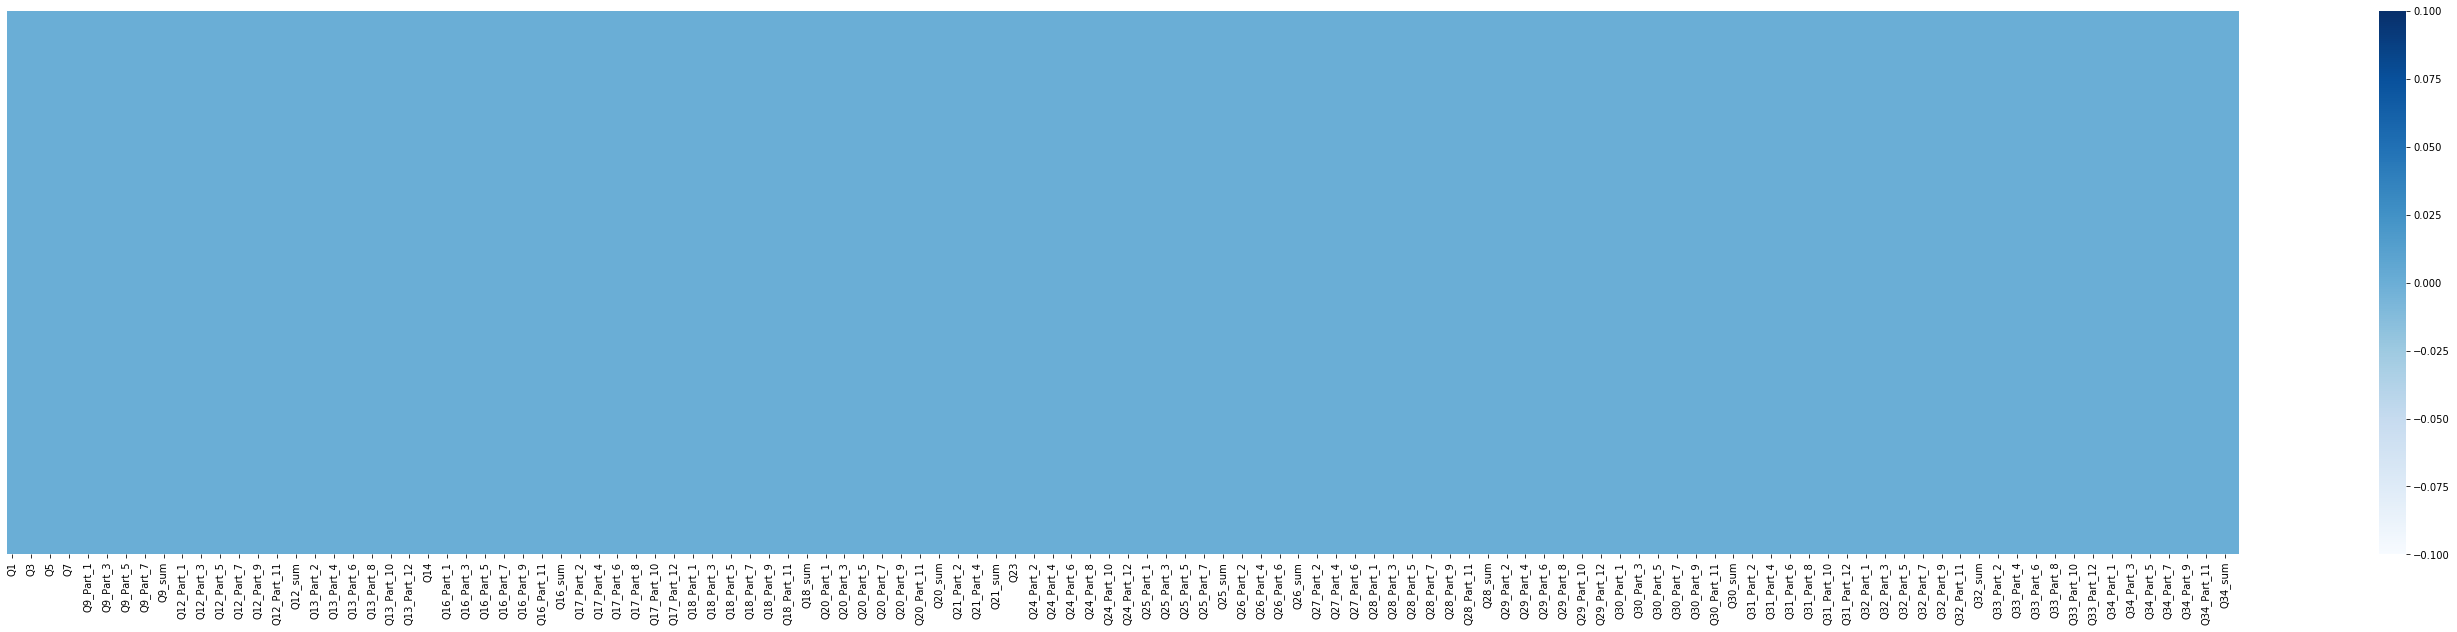

In [14]:
plt.figure(figsize=(50,10))
mv_heatmap2 = sns.heatmap(data.isnull(),cmap='Blues',yticklabels=False)
plt.xticks(rotation=90)
plt.show()

In [15]:
print("Remaining Missing Values: ",data.isnull().sum().sum())

Remaining Missing Values:  0


Now there is no missing values left and we can continue the encoding.

## Encode Nominal Questions

The questions encoded in this part are nominal questions. The answers are categorical but not with any order. In this case, 'get_dummies' is used to generate a column with ones and zeros for each category.

In [0]:
Q2_df = pd.get_dummies(data['Q2'],prefix='Q2') #Gender
Q3_df = pd.get_dummies(data['Q3'],prefix='Q3') #Country
Q4_df = pd.get_dummies(data['Q4'],prefix='Q4') #Degree
Q5_df = pd.get_dummies(data['Q5'],prefix='Q5') #current role
Q8_df = pd.get_dummies(data['Q8'],prefix='Q8') #incoop with ML
Q14_df = pd.get_dummies(data['Q14'],prefix='Q14') #primary tool
Q19_df = pd.get_dummies(data['Q19'],prefix='Q19') #used TPU


The columns with original text answers are then dropped from the dataframe.

In [0]:
data = data.drop(['Q2','Q3','Q4','Q5','Q8','Q14','Q19'],axis=1)
data = pd.concat([data,Q2_df,Q3_df,Q4_df,Q5_df,Q8_df,Q14_df,Q19_df],axis=1)

## Encode Ordinal Questions

Q1, Q6, Q7, Q11, Q15, Q22, Q23 are questions with ordinal answers and they are encoded by hand with numbers starting from 0.

In [0]:
#data['Q1'].unique()
Q1_label={'18-21':0,'22-24':1,'25-29':2, '30-34':3, '35-39':4, '40-44':5, '45-49':6, '50-54':7, '55-59':8, '60-69':9, '70+':10}
data['Q1_Encoded'] =data['Q1'].map(Q1_label)
data = data.drop(['Q1'],axis=1)

In [0]:
#data['Q6'].unique()
Q6_label={'0-49 employees':0,'50-249 employees':1,'250-999 employees':2,'1000-9,999 employees':3,
          '> 10,000 employees':4}
data['Q6_Encoded'] =data['Q6'].map(Q6_label)
data = data.drop(['Q6'],axis=1)

In [0]:
#data['Q7'].unique()
Q7_label={'0':0,'1-2':1,'3-4':2,'5-9':3,'10-14':4,'15-19':5,'20+':6}
data['Q7_Encoded'] =data['Q7'].map(Q7_label)
data = data.drop(['Q7'],axis=1)

In [0]:
#data['Q11'].unique()
Q11_label={'$0 (USD)':0,'$1-$99':1,'$100-$999':2,'$1000-$9,999':3,'$10,000-$99,999':4,'> $100,000 ($USD)':5}
data['Q11_Encoded'] =data['Q11'].map(Q11_label)
data = data.drop(['Q11'],axis=1)

In [0]:
#data['Q15'].unique()
Q15_label={'I have never written code':0,'< 1 years':1,'1-2 years':2,'3-5 years':3,'5-10 years':4,
           '10-20 years':5,'20+ years':6}
data['Q15_Encoded'] =data['Q15'].map(Q15_label)
data = data.drop(['Q15'],axis=1)

In [0]:
#data['Q22'].unique()
Q22_label={'Never':0,'Once':1,'2-5 times':2,'6-24 times':3,'> 25 times':4}
data['Q22_Encoded'] =data['Q22'].map(Q22_label)
data = data.drop(['Q22'],axis=1)

In [0]:
#data['Q23'].unique()
Q23_label={'< 1 years':0,'1-2 years':1,'2-3 years':2,'3-4 years':3,'4-5 years':4,'5-10 years':5,
           '10-15 years':6,'20+ years':7}
data['Q23_Encoded'] =data['Q23'].map(Q23_label)
data = data.drop(['Q23'],axis=1)


# Question 2: Exploratory Data Analysis

## Correlation Plot

This part is to visualize the order of feature importance. The graph plotted shows the 30 features that have the strongest correlation with responent's yearly compensation. The first four are listed below and they each will have a plot to show the trend in the next section.


1.   Whether the respondent works in the United States of America
2.   Number of years the respondent has been writing code to analyze data
3.   Number of years the respondent has been using machine learning methods
4.   The age of the respondent



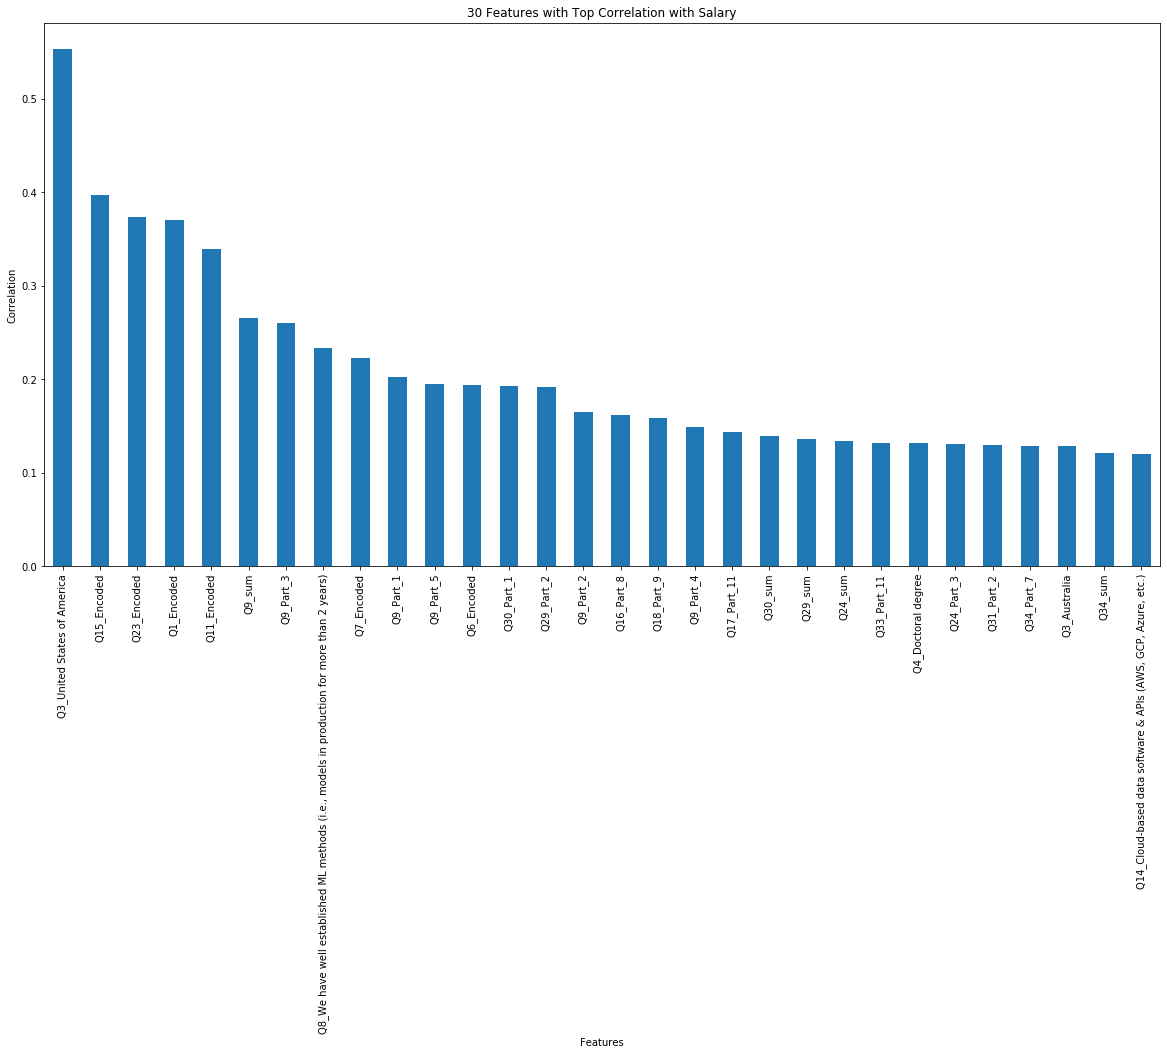

In [25]:
# Move Target to the Right End of Dataframe
cols_ = list(data.columns.values)
cols_.pop(cols_.index('Q10_Encoded'))
data = data[cols_+['Q10_Encoded']]

# Display top 30 correlations with salary
correlation_plot = data.corr()
target_corr = correlation_plot.shape[0]-1
correlation = correlation_plot.iloc[target_corr,0:-1].sort_values(ascending=False)

plt.figure(figsize=(20,10))
correlation.iloc[0:30].plot(kind='bar')
plt.title('30 Features with Top Correlation with Salary')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

## Trends in Data

In this section, the top four features are plotted to show their trend with salary.

### Country vs. Salary

The first graph shows the variation in the yearly compensation with respect to respondents' working location. Those who work in the United States of America earn the most with Australia being the second. 

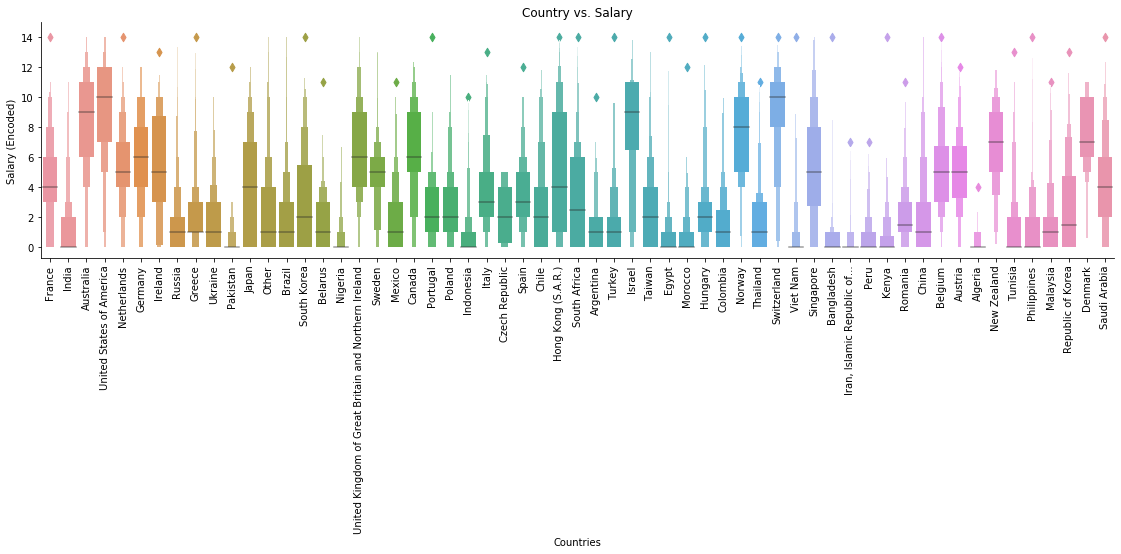

In [26]:
country = sns.catplot(x='Q3',y='Q10_Encoded',data=data_raw,kind='boxen',height=4,aspect=4)
country.set_axis_labels("Countries", "Salary (Encoded)")
plt.title("Country vs. Salary")
plt.xticks(rotation=90)
plt.show()

### Years of Writing Code vs. Salary

The trend exist in the salary with respect to years of writing code to analyze data is pretty obvious. Respondents with longer experience of writing code tend to earn more.

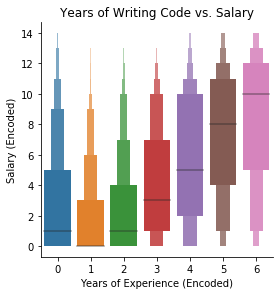

In [27]:
yrs_writing_code = sns.catplot(x='Q15_Encoded',y='Q10_Encoded',data=data,kind="boxen",height=4,aspect=1)
yrs_writing_code.set_axis_labels("Years of Experience (Encoded)", "Salary (Encoded)")
plt.title("Years of Writing Code vs. Salary")
plt.show()

### Years of Using Machine Learning Methods vs. Salary

As shown in the plot below, years of using machine learning methods is also proportional to the yearly compensation of the correspondent.

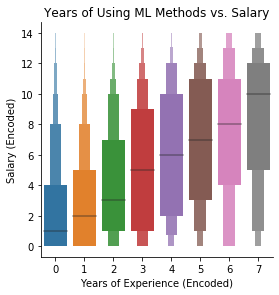

In [28]:
yrs_ML = sns.catplot(x='Q23_Encoded',y='Q10_Encoded',data=data,kind="boxen",height=4,aspect=1)
yrs_ML.set_axis_labels("Years of Experience (Encoded)", "Salary (Encoded)")
plt.title("Years of Using ML Methods vs. Salary")
plt.show()

### Age vs. Salary

Age of the respondent is often correlates with their years of experience and thus similar trend exists here. Elder respondents tend to earn more and this trend is especially obvious in early years of career.

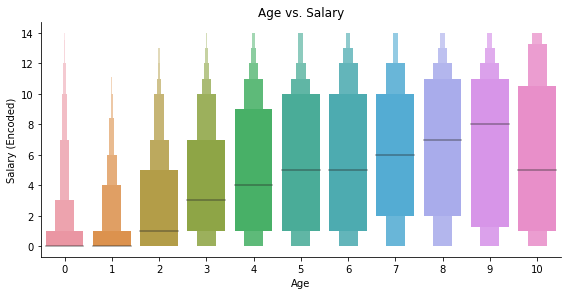

In [29]:
country = sns.catplot(x='Q1_Encoded',y='Q10_Encoded',data=data,kind='boxen',height=4,aspect=2)
country.set_axis_labels("Age", "Salary (Encoded)")
plt.title("Age vs. Salary")
plt.show()

# Question 3: Feature Selection

Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data. The process could be consisted of identifying feature importance, feature extraction, feature selection and feature construction.

Irrelevant or partially relevant features can negatively impact model performance and that is why we need feature selection. The three common algorithms used in feature selection differ in their evaluation metrics:


1.   Wrapper methods use a predictive model to score feature subsets. Each new subset is used to train a model, and the model is tested to obtain a score. This type of methods is very computationally intensive, but usually provide the best performing feature set for the problem.
2.   Filter methods use a proxy measure instead of the error rate to score a feature subset. The feature set doesn't contain the assumptions of a prediction model, and so is more useful for exposing the relationships between the features. In this case, many filters provide a feature ranking rather than an explicit best feature subset.
3.   Embedded methods are a catch-all group of techniques which perform feature selection as part of the model construction process. 



## Feature Selection using Random Forest

Random forests are one the most popular machine learning algorithms, which provides a good predictive performance, low overfitting, and easy interpretability. It belongs to the category of embedded methods.

Random forests consist of 4 –12 hundred decision trees, each of them built over a random extraction of the observations from the dataset and a random extraction of the features. Not every tree sees all the features or all the observations, and this guarantees that the trees are de-correlated and therefore less prone to over-fitting. Each tree is also a sequence of yes-no questions based on a single or combination of features. At each node, the tree divides the dataset into 2 buckets, each of them hosting observations that are more similar among themselves and different from the ones in the other bucket. Therefore, the importance of each feature is derived from how “pure” each of the buckets is.

In [0]:
y = data['Q10_Encoded']
X = data.drop(['Q10_Encoded'],axis=1)

In [0]:
scaler = StandardScaler()
data_std = scaler.fit_transform(X)
data_std_ = pd.DataFrame(data_std)

In [32]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn import model_selection

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [33]:
selection = SelectFromModel(RandomForestClassifier(n_estimators = 10))
selection.fit(data_std_, y)
#selection.get_support()

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10, n_jobs=None,
                                                 oob_score=False,


In [34]:
selected_feat = data_std_.columns[(selection.get_support())]
print('total features: {}'.format((data_std.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 333
selected features: 119


In [0]:
selected_list=[]
for i in range(len(selected_feat)):
    selected_list.append(selected_feat[i])

data_RF = data_std_[data_std_.columns.intersection(selected_list)]

In [36]:
print('Number of Features left: ', data_RF.shape[1])

Number of Features left:  119


## Further Feature Selection using Principle Component Analysis (PCA)

The number of remaining features is still high (around 120), in this case, Principle Component Analysis is used to further reduce the dimensions of the dataset.

In [0]:
# Further reduce the features in half and obtain 60 features left
from sklearn.decomposition import PCA
pca = PCA(n_components = 60)
pca.fit(data_RF)
X_sel = pca.fit_transform(data_RF)

#convert it to dataframe
X_sel = pd.DataFrame(X_sel)

In [38]:
print('Number of Features left: ', X_sel.shape[1])

Number of Features left:  60


# Question 4: Model Implementation

## Split Training and Test Set

The data is split into 70% training and 30% test sets.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, random_state=1, test_size=0.3)

## Logistic Regression using 10-Fold Cross-Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as in this question, k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model. It generally results in a less biased or less optimistic estimate of the model skill.

In [0]:
# Obtain logistic regression and cross validation results
LR_model = LogisticRegression(penalty='l1',C=1.0,solver='liblinear') #use logistic model with L1
results = cross_val_score(LR_model, X_train, y_train, cv=10)

In [41]:
# Print accuracy resuls
for i in range(10):
    score = results[i] * 100
    print("Fold "+str(i+1)+" Accuracy: "+str(round(score,3))+"%")

# Print average accuracy and variance
score_avg = results.mean()*100
score_std = results.std()*100
score_var = pow(score_std,2)
print("Average Accuracy: "+str(round(score_avg,3))+"%") 
print("Variance of Accuracy: "+str(round(score_var,3))+"%")

Fold 1 Accuracy: 36.114%
Fold 2 Accuracy: 35.429%
Fold 3 Accuracy: 36.914%
Fold 4 Accuracy: 35.314%
Fold 5 Accuracy: 34.629%
Fold 6 Accuracy: 35.886%
Fold 7 Accuracy: 34.514%
Fold 8 Accuracy: 35.355%
Fold 9 Accuracy: 35.011%
Fold 10 Accuracy: 35.584%
Average Accuracy: 35.475%
Variance of Accuracy: 0.456%


## Treating Each Value of Hyperparameter as a New Model

In this section, 12 values of inverse regularization strength are implemented in 12 models to obtain their scores.

In [42]:
c = [0.001,.009,0.01,.09,1,5,10,25,50,100,500,1000]
for i in range(12):
    model= LogisticRegression(penalty='l1',C=c[i],solver='liblinear')
    model.fit(X_train, y_train)
    accuracy = round(model.score(X_test, y_test),3)
    print("Model",i+1,"Score:",accuracy)

Model 1 Score: 0.314
Model 2 Score: 0.331
Model 3 Score: 0.332
Model 4 Score: 0.347
Model 5 Score: 0.345
Model 6 Score: 0.344
Model 7 Score: 0.344
Model 8 Score: 0.344
Model 9 Score: 0.344
Model 10 Score: 0.344
Model 11 Score: 0.344
Model 12 Score: 0.343


The model with highest score corresponds to a C of 1.0.

# Question 5: Model Tuning

## Grid Search

In this section, the hyperparameter C and regularization method (L1 or L2) are tuned to find the optimal model. The tuning is carried out by grid search.

In [0]:
clf = LogisticRegression(solver='liblinear')
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25,50,100,500,1000]}
grid_clf_acc = GridSearchCV(clf,param_grid = grid_values,cv=10)
optimal = grid_clf_acc.fit(X_train, y_train)

In [44]:
print('C:', optimal.best_estimator_.get_params()['C'])
print('Penalty:', optimal.best_estimator_.get_params()['penalty'])
print("Accuracy :",optimal.best_score_)

C: 1
Penalty: l1
Accuracy : 0.3547496567505721


In [50]:
final_model = LogisticRegression(penalty='l1',C=1.0, solver='liblinear')
final_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

# Question 6: Testing and Discussion

## Testing of the model

The model is run on the test set and the results are displayed as below.

In [0]:
y_pred = final_model.predict(X_test)

In [52]:
from sklearn.metrics import classification_report
final_result = classification_report(y_test,y_pred,digits=3)
print(final_result)

              precision    recall  f1-score   support

           0      0.424     0.938     0.584      1177
           1      0.096     0.033     0.049       395
           2      0.124     0.038     0.058       340
           3      0.125     0.028     0.046       215
           4      0.140     0.027     0.045       226
           5      0.109     0.029     0.045       209
           6      0.138     0.047     0.070       170
           7      0.192     0.029     0.050       175
           8      0.083     0.018     0.030       111
           9      0.000     0.000     0.000       109
          10      0.171     0.249     0.203       217
          11      0.221     0.207     0.214       150
          12      0.276     0.255     0.265       145
          13      0.000     0.000     0.000        47
          14      0.159     0.109     0.130        64

    accuracy                          0.345      3750
   macro avg      0.151     0.134     0.119      3750
weighted avg      0.226   

The precision, recall and f1-score are listed in the table above. The overall accuracy is 0.34 which generally aligns with that of the training set, only slightly lower. Classes with more support tend to have higher precision, recall and f1 score.

## Results Display and Discussion

First of all we need to decode the salary to use as labels of the distribution plot.

In [0]:
salary_decode = {'$0-9999': 0,'10,000-19,999': 1,'20,000-29,999': 2,'30,000-39,999': 3, 
                 '40,000-49,999': 4,'50,000-59,999': 5,'60,000-69,999': 6,'70,000-79,999': 7, 
                 '80,000-89,999': 8,'90,000-99,999': 9,'100,000-124,999':10,'125,000-149,999':11,
                 '150,000-199,999':12,'200,000-249,999':13,'>250,000':14}

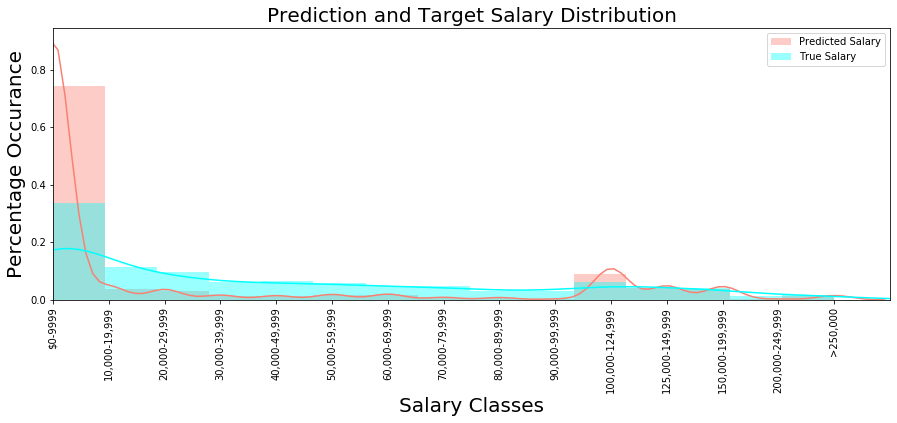

In [54]:
f, ax = plt.subplots(figsize=(15,5))
sns.distplot(y_pred, bins=15,  color="salmon",label='Predicted Salary').set_xticklabels(salary_decode.keys())
sns.distplot(y_test, bins=15, color="aqua",label='True Salary')
ax.set_xticks(range(15))
plt.xticks(rotation=90)
ax.set_title('Prediction and Target Salary Distribution',fontsize=20)
ax.set_xlabel('Salary Classes',fontsize=20)
ax.set_ylabel('Percentage Occurance',fontsize=20)
plt.xlim(0,15)
plt.legend()
plt.show()


According to the distribution plot, the model overpredicts the lowest salary bucket and underpredict the higher ones. This may be attributed to the unevenly distributed samples. Most respondents fall into the first several buckets while buckets with higher salaries receive fewer samples. Generally, the performance of the model is not very good.

To improve the accuracy of training set, one way is to be more careful when encoding the dataset. Some of the options in the multiple choice questions such as 'Other' may require more appropriate handling as we do not know what 'Other' actually is. Performing cross validation with more folds is also an option. For training and test sets generally, improving accuracy can be achieved by obtaining more samples, especially those fall into buckets with higher salaries. Additionally, the classes can be combined so the samples are more aggregated and better for prediction.